In [1]:
# Importing useful packages.
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Importing our utilitary modules.
import src.utils as utils

In [2]:
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, GridSearchCV
import scipy.sparse
import scipy.stats
import time

from sklearn.metrics import r2_score, explained_variance_score, max_error, mean_squared_error, median_absolute_error, make_scorer
from sklearn.svm import LinearSVC

In [3]:
# Defining constants.
DATA_DIR = 'Data'
CACHE_DIR = 'Cache'
SPEAKER_INFO_FILE_PATH = os.path.join(DATA_DIR, 'speaker_attributes.parquet')
PREPROCESSED_DATASET_FILE_PATH = os.path.join(CACHE_DIR, "preprocessed_dataset.json.bz2")

In [4]:
@utils.cache_to_file_pickle("function-make_features_labels_arrays", cache_dir = CACHE_DIR, ignore_kwargs = ['batch_size'])
def make_features_labels_arrays(preprocessed_dataset_file_path, batch_size = 1000000):    
    return features, num_occurrences, features_cols_titles

In [5]:
def remove_quotes_unknown_topics(features, num_occurrences, features_cols_titles):
    # Remove quotes with unknown topic.
    unknown_topic_col = features_cols_titles.index('quotation_topic_UNKNOWN')
    mask_rows = features[:, unknown_topic_col].toarray().ravel() == 0  
    features = features[mask_rows, :]
    num_occurrences = num_occurrences[mask_rows]
    
    # Remove topic column (useless as all-zeros).
    mask_cols = np.arange(len(features_cols_titles)) != unknown_topic_col    
    features = features[:, mask_cols]
    features_cols_titles.pop(unknown_topic_col)
    
    return features, num_occurrences, features_cols_titles

def get_very_stratifier(targets, percentile_step = 5e-5):

    # Make bins of number of occurrences used to stratify.    
    bins = np.percentile(targets, np.arange(0, 100, percentile_step), interpolation = 'nearest')
    bins = np.unique(bins)
    stratifier = np.digitize(targets, bins)

    return stratifier

In [6]:
def linear_svm_cv(features, labels, cv_n_splits = 10, n_jobs = 1, verbose = True):    
    
    print(f"Training on {len(labels)} samples with {features.shape[1]} features")
    print(f"Positive samples: {np.sum(labels == 1)}, negative samples: {np.sum(labels == 0)}")
         
    folds = list(StratifiedKFold(n_splits = cv_n_splits, shuffle = True).split(np.zeros_like(labels), labels))  
     
    # class_weight = 'balanced' ???
    results = cross_validate(estimator  = LinearSVC(dual = False, max_iter = 10000), X = features, y = labels,
                             cv         = folds,              
                             scoring    = {'accuracy' : 'accuracy',
                                           'precision': 'precision',
                                           'recall'   : 'recall',
                                           'f1'       : 'f1',
                                           'sparsity' : lambda estimator, X, y: np.mean(np.abs(estimator.coef_) < 1e-8)},
                             return_train_score = True,
                             n_jobs = n_jobs,
                             verbose = 2 if verbose else 0)
    return results

In [35]:
np.random.seed(0xADA)
VIRAL_THR = 3

features, num_occurrences, features_cols_titles = make_features_labels_arrays(preprocessed_dataset_file_path = PREPROCESSED_DATASET_FILE_PATH)
features, num_occurrences, features_cols_titles = remove_quotes_unknown_topics(features, num_occurrences, features_cols_titles)
features_train, features_test, repeatable_label_train, repeatable_label_test = train_test_split(features, np.uint8(num_occurrences >= VIRAL_THR), test_size = 0.3, shuffle = True, stratify = get_very_stratifier(num_occurrences))
results = linear_svm_cv(features_train, repeatable_label_train)

Training on 20980045 samples with 626 features
Positive samples: 4478772, negative samples: 16501273


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time= 2.9min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.4min remaining:    0.0s


[CV] END .................................................... total time= 3.0min
[CV] END .................................................... total time= 3.0min
[CV] END .................................................... total time= 2.9min
[CV] END .................................................... total time= 3.0min
[CV] END .................................................... total time= 2.9min
[CV] END .................................................... total time= 2.9min
[CV] END .................................................... total time= 2.9min
[CV] END .................................................... total time= 2.9min
[CV] END .................................................... total time= 2.8min


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 33.3min finished


In [36]:
results

{'fit_time': array([174.04998755, 178.01831293, 174.91157913, 172.80200434,
        177.67742515, 174.19187832, 171.60582447, 171.33256674,
        172.61173368, 162.87762427]),
 'score_time': array([2.39512444, 2.5251267 , 2.31830668, 2.35319138, 2.44929004,
        2.35377312, 2.3262918 , 2.32213664, 2.30944324, 2.32915759]),
 'test_accuracy': array([0.78651004, 0.78652529, 0.78651719, 0.78651385, 0.78652339,
        0.78650708, 0.78652043, 0.78650231, 0.78651232, 0.7865209 ]),
 'train_accuracy': array([0.78651549, 0.78651311, 0.78651396, 0.78651433, 0.78651343,
        0.78651513, 0.78652112, 0.78651561, 0.7865145 , 0.78651365]),
 'test_precision': array([0.4109589 , 0.51530612, 0.46666667, 0.45728643, 0.50847458,
        0.41836735, 0.44736842, 0.39393939, 0.44615385, 0.49171271]),
 'train_precision': array([0.4536903 , 0.44878626, 0.45385068, 0.45476333, 0.45017794,
        0.46003552, 0.47058824, 0.46153846, 0.45521024, 0.45163205]),
 'test_recall': array([1.33965352e-04, 2.25508

From these results, we can see svm predicts is bad.

Let's retry balancing the loss.

In [37]:
def linear_svm_cv(features, labels, cv_n_splits = 10, n_jobs = 1, verbose = True):    
    
    print(f"Training on {len(labels)} samples with {features.shape[1]} features")
    print(f"Positive samples: {np.sum(labels == 1)}, negative samples: {np.sum(labels == 0)}")
         
    folds = list(StratifiedKFold(n_splits = cv_n_splits, shuffle = True).split(np.zeros_like(labels), labels))  
    
    results = cross_validate(estimator  = LinearSVC(dual = False, max_iter = 10000, class_weight = 'balanced'), X = features, y = labels,
                             cv         = folds,              
                             scoring    = {'accuracy' : 'accuracy',
                                           'precision': 'precision',
                                           'recall'   : 'recall',
                                           'f1'       : 'f1',
                                           'sparsity' : lambda estimator, X, y: np.mean(np.abs(estimator.coef_) < 1e-8)},
                             return_train_score = True,
                             n_jobs = n_jobs,
                             verbose = 2 if verbose else 0)
    return results

In [38]:
np.random.seed(0xADA)
VIRAL_THR = 3

features, num_occurrences, features_cols_titles = make_features_labels_arrays(preprocessed_dataset_file_path = PREPROCESSED_DATASET_FILE_PATH)
features, num_occurrences, features_cols_titles = remove_quotes_unknown_topics(features, num_occurrences, features_cols_titles)
features_train, features_test, repeatable_label_train, repeatable_label_test = train_test_split(features, np.uint8(num_occurrences >= VIRAL_THR), test_size = 0.3, shuffle = True, stratify = get_very_stratifier(num_occurrences))
results = linear_svm_cv(features_train, repeatable_label_train)

Training on 20980045 samples with 626 features
Positive samples: 4478772, negative samples: 16501273


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time= 3.7min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  4.1min remaining:    0.0s


[CV] END .................................................... total time= 3.6min
[CV] END .................................................... total time= 3.4min
[CV] END .................................................... total time= 3.7min
[CV] END .................................................... total time= 3.9min
[CV] END .................................................... total time= 3.7min
[CV] END .................................................... total time= 3.6min
[CV] END .................................................... total time= 3.7min
[CV] END .................................................... total time= 3.7min
[CV] END .................................................... total time= 3.4min


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed: 40.8min finished


In [39]:
results

{'fit_time': array([216.35729647, 215.21656728, 202.06312442, 218.43421555,
        229.24264979, 220.04649854, 215.98633671, 218.38077879,
        219.53338146, 201.47886491]),
 'score_time': array([2.78905845, 2.63198709, 2.63247633, 2.66497564, 2.55172586,
        2.59604788, 2.59504557, 2.60983706, 2.56846189, 2.62263298]),
 'test_accuracy': array([0.56133565, 0.5621836 , 0.56135424, 0.56175462, 0.56108446,
        0.56181685, 0.56105327, 0.56167719, 0.56182352, 0.56152038]),
 'train_accuracy': array([0.56163725, 0.56156093, 0.56160929, 0.56171394, 0.56161554,
        0.56166116, 0.56176549, 0.56172704, 0.56156593, 0.56177137]),
 'test_precision': array([0.26152178, 0.26205681, 0.26161343, 0.26149453, 0.26122252,
        0.26168033, 0.2610256 , 0.26153439, 0.26167729, 0.26161704]),
 'train_precision': array([0.26163069, 0.26158601, 0.26162535, 0.26166737, 0.26167245,
        0.26165454, 0.26170958, 0.26164312, 0.26161425, 0.26164416]),
 'test_recall': array([0.57838871, 0.5786879 ,

In [7]:
from sklearn.tree import DecisionTreeClassifier

In [43]:
def plot_pruning_alphas_vs_impurities(X_train, y_train, clf, downsampling_factor):
    
    if downsampling_factor > 1:
        X_train, _, y_train, _ = train_test_split(X_train, y_train, train_size = 1 / downsampling_factor, shuffle = True, stratify = get_very_stratifier(y_train))
        
    path = clf.cost_complexity_pruning_path(X_train, y_train)
    ccp_alphas, impurities = path.ccp_alphas, path.impurities

    fig, ax = plt.subplots()
    ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
    ax.set_xlabel("effective alpha")
    ax.set_ylabel("total impurity of leaves")
    ax.set_title("Total Impurity vs effective alpha for training set")
    
    return ccp_alphas, impurities

In [44]:
np.random.seed(0xADA)
VIRAL_THR = 3

features, num_occurrences, features_cols_titles = make_features_labels_arrays(preprocessed_dataset_file_path = PREPROCESSED_DATASET_FILE_PATH)
features, num_occurrences, features_cols_titles = remove_quotes_unknown_topics(features, num_occurrences, features_cols_titles)
features_train, features_test, repeatable_label_train, repeatable_label_test = train_test_split(features, np.uint8(num_occurrences >= VIRAL_THR), test_size = 0.3, shuffle = True, stratify = get_very_stratifier(num_occurrences))

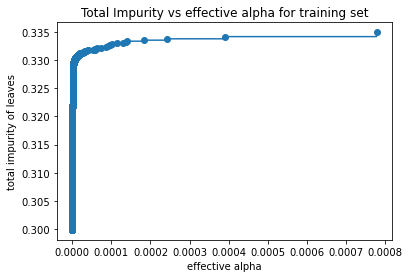

In [45]:
ccp_alphas, impurities = plot_pruning_alphas_vs_impurities(features_train, repeatable_label_train, DecisionTreeClassifier(max_depth = 50), downsampling_factor = 10)

Text(0, 0.5, 'total impurity of leaves')

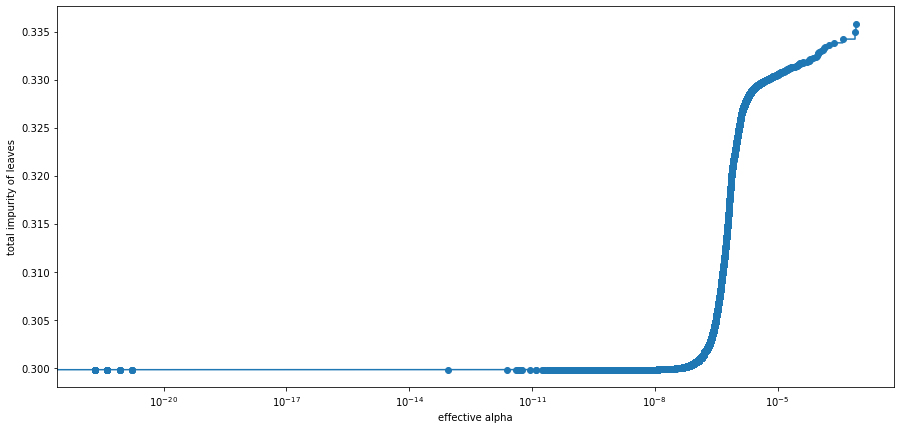

In [59]:
fig, ax = plt.subplots()
ax.plot(ccp_alphas, impurities, marker="o", drawstyle="steps-post")
plt.xscale('log')
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
#ax.set_title("Total Impurity vs effective alpha for training set")

In [8]:
from copy import deepcopy

from sklearn.metrics import r2_score, explained_variance_score, max_error, mean_squared_error, median_absolute_error, make_scorer


def tree_classif_cv(features, repeatable_label, ccp_alphas, cv_n_splits = 10, verbose = True):
    
    print("Training on {} samples with {} features".format(*features.shape))
    
    folds = list(StratifiedKFold(n_splits = cv_n_splits, shuffle = True).split(np.zeros_like(repeatable_label), repeatable_label))
    
    # Train on single fold, validate on all other folds for computational cost reasons.
    folds = [elem[::-1] for elem in folds]
        
    results = []
    
    # Train on single fold, evaluate on all other folds for computational cost reasons.
    for i, (train_index, val_index) in enumerate(folds):
        if verbose:
            print(f"Starting Fold {i + 1} of {len(folds)}")
            start = time.time()
        
        features_train = features[train_index]
        features_val   = features[val_index]
        repeatable_label_train = repeatable_label[train_index]
        repeatable_label_val   = repeatable_label[val_index]
        
        unpruned_model = DecisionTreeClassifier(max_depth = 50).fit(features_train, repeatable_label_train) 
        
        current_fold_results = {alpha: {'train_scores': {}, 'val_scores': {}} for alpha in ccp_alphas}
        
        for alpha in ccp_alphas:
            model = deepcopy(unpruned_model)
            model.set_params(ccp_alpha = alpha)
            model._prune_tree()
                        
            for key, (X, y) in zip(['train_scores', 'val_scores'], [(features_train, repeatable_label_train), (features_val, repeatable_label_val)]):
                preds = model.predict(X)

                current_fold_results[alpha][key]['accuracy']              = accuracy_score(y, preds)
                current_fold_results[alpha][key]['precision']             = precision_score(y, preds)
                current_fold_results[alpha][key]['recall']                = recall_score(y, preds)
                current_fold_results[alpha][key]['f1']                    = f1_score(y, preds)
            
        results.append(current_fold_results)
            
        if verbose:
            print(f"Finished Fold {i + 1} of {len(folds)} in {time.time() - start} seconds")

    return results

In [ ]:
np.random.seed(0xADA)
VIRAL_THR = 3

features, num_occurrences, features_cols_titles = make_features_labels_arrays(preprocessed_dataset_file_path = PREPROCESSED_DATASET_FILE_PATH)
features, num_occurrences, features_cols_titles = remove_quotes_unknown_topics(features, num_occurrences, features_cols_titles)
features_train, features_test, repeatable_label_train, repeatable_label_test = train_test_split(features, np.uint8(num_occurrences >= VIRAL_THR), test_size = 0.3, shuffle = True, stratify = get_very_stratifier(num_occurrences))
results = tree_classif_cv(features_train, repeatable_label_train, [0] + list(np.geomspace(1e-9, 1e-4, num = 51)))

Training on 20980045 samples with 626 features
Starting Fold 1 of 10


In [ ]:
results